In [1]:
import numpy as np
import torch
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader,Dataset
from torchvision import datasets, transforms
from torch.utils.data import random_split
from FreeformTry import DeformationLayer
import matplotlib.pyplot as plt
from torch import nn, optim
from deepali.core import functional as U
from tqdm import tqdm

ModuleNotFoundError: No module named 'FreeformTry'

In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [3]:
data_path = '/home/ubuntu/ADLM/Pracktikum/data/MNIST'

# Load the MNIST dataset without labels
mnist_dataset = MNIST(data_path, train=True, download=True, transform=None)
images = mnist_dataset.data

# Print the shape of the images tensor
print(images.shape)
print(type(images))

torch.Size([60000, 28, 28])
<class 'torch.Tensor'>


Files already downloaded and verified


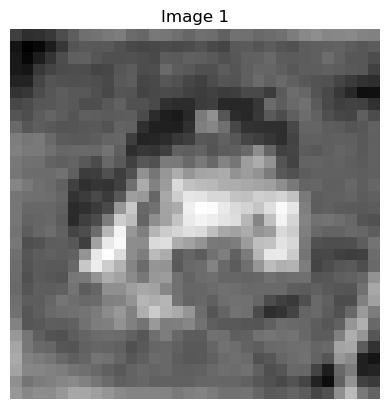

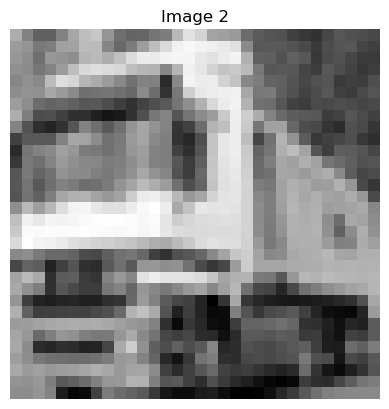

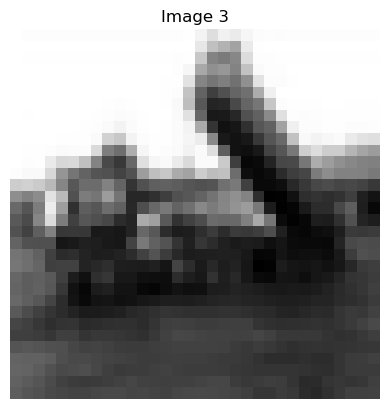

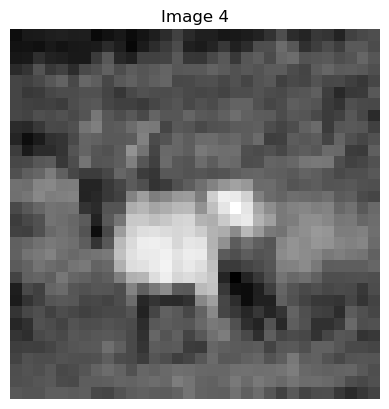

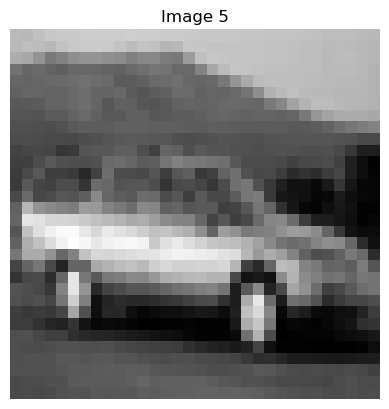

torch.Size([50000, 32, 32])
<class 'torch.Tensor'>


In [4]:
data_path = '/home/ubuntu/ADLM/Pracktikum/data/Cifar'
cifar10_dataset = datasets.CIFAR10(data_path, train=True, download=True, transform=None)
images_cifar10 = cifar10_dataset.data

# Convert to black and white
images = np.mean(images_cifar10, axis=3)
images = torch.from_numpy(images)
num_images_to_show = 5
for i in range(num_images_to_show):
    plt.imshow(images[i], cmap='gray')
    plt.title(f'Image {i+1}')
    plt.axis('off')
    plt.show()
print(images.shape)
print(type(images))

In [5]:
import random
random_fraction = 1/20
random_indices = random.sample(range(len(images)), int(random_fraction * len(images)))
images = images[random_indices]
print(images.shape)

transform = transforms.Resize((32, 32))
images = transform(images)
print(images.shape)
#print(type(images))
#print(images[0][:][:].max())


torch.Size([2500, 32, 32])
torch.Size([2500, 32, 32])


In [6]:
def get_mean_std(tensor):
    # Calculate the mean of the tensor
    mean = tensor.float().mean()
    
    # Calculate the standard deviation of the tensor
    std = tensor.float().std()
    
    return mean.item(), std.item()

mean, std = get_mean_std(images)
print(mean, std)

120.68592834472656 61.356483459472656


In [7]:
class CustomDataset(Dataset):
    def __init__(self, images, shape,transform=None, device = "cpu"):
        """
        Args:
            images (torch.Tensor): The tensor containing image data.
            shape: The shape of one image in the dataset.
            mean (float): The mean value for normalization.
            std (float): The standard deviation for normalization.
            transform (bool): Whether to apply the transformation.
        """
        self.images = images
        self.shape = shape
        self.transform = transform
        self.device = device
    
    def __len__(self):
        return len(self.images)
    
    def build_deformation_layer(self, device):
        """
        Build and return a new deformation layer for each call to __getitem__.
        This method returns the created deformation layer.
        """
        deformation_layer = DeformationLayer(self.shape)
        deformation_layer.new_deformation(device=device)
        return deformation_layer

    def __getitem__(self, idx):
        # Fetch the original image
        original_image = self.images[idx].unsqueeze(0)  # Add batch dimension
        original_image = original_image.to(self.device)

        # Build a new deformation layer for the current image
        deformation_layer = self.build_deformation_layer(self.device).to(self.device)

        # Apply deformation to get the deformed image
        deformed_image = deformation_layer.deform(original_image)
        # Fetch the current deformation field
        deformation_field = deformation_layer.get_deformation_field().squeeze(0).to(self.device)
        
        # transform the images
        if self.transform:
            original_image = self.transform(original_image)
            deformed_image = self.transform(deformed_image)
            #print('mean and std of original image: ', original_image.mean(), original_image.std())
            #print('max and min of original image: ', original_image.max(), original_image.min())

        # Stack the original and deformed images along the channel dimension
        stacked_image = torch.cat([original_image, deformed_image], dim=0).squeeze(0)

        return stacked_image, deformation_field

In [8]:
shape = images[0].shape[-2:]  # Image dimensions (height, width)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Create dataset
dataset = CustomDataset(images, 
                        shape, 
                        transform=transforms.Compose([
                            transforms.Normalize(mean = [mean], std = [std]) ]), device = device
                        )
# trainset and testset
train_size = int(0.6 * len(dataset))
val_size = int(0.2 * len(dataset))
test_size = len(dataset) - train_size - val_size
train_dataset, val_dataset, test_dataset = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Define the DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)

Max value of normalized images: 2.1890773287680347
Min value of normalized images: -1.9669629277962506
Max value of renormalized images: 1.0
Min value of renormalized images: 0.0
Batch Images Shape: torch.Size([32, 2, 32, 32])
Batch Deformation Fields Shape: torch.Size([32, 2, 32, 32])


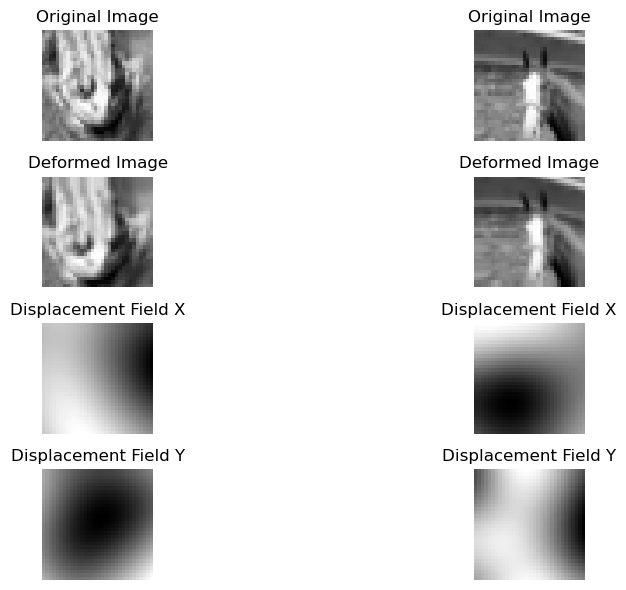

In [9]:
def renormalize(tensor):
        minFrom= tensor.min()
        maxFrom= tensor.max()
        minTo = 0
        maxTo=1
        return minTo + (maxTo - minTo) * ((tensor - minFrom) / (maxFrom - minFrom))

data_iter = iter(train_loader)
images, deformation_fields = next(data_iter)
print('Max value of normalized images:', float(images.max()))
print('Min value of normalized images:', float(images.min()))
images = renormalize(images)
print('Max value of renormalized images:', float(images.max()))
print('Min value of renormalized images:', float(images.min()))
# Printing shapes to ensure they are correct
print("Batch Images Shape:", images.shape)  # Should match [batch_size, channels, height, width]
print("Batch Deformation Fields Shape:", deformation_fields.shape)  # Should match expected format, e.g., [batch_size, 2, height, width]


# Define the number of samples to display
num_samples = 2

# Create a figure with subplots in a grid 2x4
fig, axes = plt.subplots(4, num_samples, figsize=(12, 6))

for i in range(num_samples):
    # Plotting the original and deformed images
    
    ax = axes[0, i]
    ax.imshow(images[i,0,:,:].cpu().numpy(), cmap='gray') # Original image
    ax.title.set_text('Original Image')
    ax.axis('off')

    ax = axes[1, i]
    ax.imshow(images[i,1].cpu().numpy(), cmap='gray') # Deformed image
    ax.title.set_text('Deformed Image')
    ax.axis('off')

    ax = axes[2, i] 
    ax.imshow(deformation_fields[i, 0].cpu().numpy(), cmap='gray')  # X-component of the field
    ax.title.set_text('Displacement Field X')
    ax.axis('off')

    ax = axes[3, i] 
    ax.imshow(deformation_fields[i, 1].cpu().numpy(), cmap='gray')  # Y-component of the field
    ax.title.set_text('Displacement Field Y')
    ax.axis('off')

plt.tight_layout()
plt.show()

In [10]:
# set up u net model
from diffusion_unet import Unet
model = Unet(
    dim=8,  # Starting number of filters
    init_dim=None,
    out_dim=2,  # Output channels for x and y deformation fields
    dim_mults=(1, 2, 4, 8),  # Multipliers for the channel dimensions at each stage
    channels=2,  # Input has 2 channels (original and deformed images)
    resnet_block_groups=8,  # Number of groups for grouped convolution in Resnet blocks, tweak as needed
    learned_variance=False,  # Set based on whether you need to predict variance alongside deformation
    conditional_dimensions=0,  # Adjust if you use conditional inputs
    patch_size=1,  # Use 1 to avoid patching (since your data is already fairly low resolution)
    attention_layer=None  # Define layers where attention should be applied, if necessary
    
)

model.to(device)

Attention lvl 0 8 8
Attention lvl 1 8 16
Attention lvl 2 16 32
Attention lvl 3 32 64


Unet(
  (init_conv): Conv2d(2, 8, kernel_size=(7, 7), stride=(1, 1), padding=(3, 3))
  (time_mlp): Sequential(
    (0): SinusoidalPosEmb()
    (1): Linear(in_features=8, out_features=32, bias=True)
    (2): GELU(approximate='none')
    (3): Linear(in_features=32, out_features=32, bias=True)
  )
  (downs): ModuleList(
    (0): ModuleList(
      (0-1): 2 x ResnetBlock(
        (mlp): Sequential(
          (0): SiLU()
          (1): Linear(in_features=32, out_features=16, bias=True)
        )
        (block1): Block(
          (proj): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(8, 8, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (block2): Block(
          (proj): Conv2d(8, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm): GroupNorm(8, 8, eps=1e-05, affine=True)
          (act): SiLU()
        )
        (res_conv): Identity()
      )
      (2): Residual(
        (fn): PreNorm(
          (fn): LinearAt

In [11]:
criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.004, weight_decay=1e-5)

In [13]:
n_epochs = 10
for epoch in range(n_epochs):
    model.train()
    train_loss = 0
    # Initialize tqdm progress bar for the training batches
    train_bar = tqdm(enumerate(train_loader), total=len(train_loader), desc=f'Training Epoch {epoch+1}/{n_epochs}')
    for i, (images, deformation_field) in train_bar:
        # Move data to the device
        images = images.float().to(device)
        deformation_field = deformation_field.to(device)
        
        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(images)

        # Compute the loss
        loss = criterion(outputs, deformation_field)
        train_loss += loss.item()

        # Backward pass
        loss.backward()

        # Update the weights
        optimizer.step()

        # Update the progress bar with the latest loss information
        train_bar.set_postfix(loss=loss.item())
    
    # Compute the average training loss
    avg_train_loss = train_loss / len(train_loader)
    
    # Validate
    model.eval()
    val_loss = 0
    # Initialize tqdm progress bar for the validation batches
    val_bar = tqdm(enumerate(val_loader), total=len(val_loader), desc='Validation')
    with torch.no_grad():
        for i, (images, deformation_field) in val_bar:
            # Move validation data to the device
            images = images.float().to(device)
            deformation_field = deformation_field.to(device)
            
            outputs = model(images)
            batch_loss = criterion(outputs, deformation_field).item()
            val_loss += batch_loss
            
            # Update the progress bar for validation
            val_bar.set_postfix(val_loss=batch_loss)
        
        # Compute the average validation loss
        avg_val_loss = val_loss / len(val_loader)
        print(f'Validation Loss: {avg_val_loss}')

Validation: 100%|██████████| 16/16 [00:05<00:00,  3.04it/s, val_loss=0.00789]


Validation Loss: 0.007336099573876709


Validation: 100%|██████████| 16/16 [00:05<00:00,  3.05it/s, val_loss=0.00685]


Validation Loss: 0.0067954073019791394


Validation: 100%|██████████| 16/16 [00:05<00:00,  3.06it/s, val_loss=0.00738]


Validation Loss: 0.006364544329699129


Validation: 100%|██████████| 16/16 [00:05<00:00,  3.09it/s, val_loss=0.00405]


Validation Loss: 0.004967314598616213


Validation: 100%|██████████| 16/16 [00:05<00:00,  3.05it/s, val_loss=0.00524]


Validation Loss: 0.0047107784484978765


Validation: 100%|██████████| 16/16 [00:05<00:00,  3.08it/s, val_loss=0.00516]


Validation Loss: 0.004517567838774994


Validation: 100%|██████████| 16/16 [00:05<00:00,  3.06it/s, val_loss=0.0045] 


Validation Loss: 0.0037222338432911783


Validation: 100%|██████████| 16/16 [00:05<00:00,  3.06it/s, val_loss=0.0039] 


Validation Loss: 0.00372569051978644


Validation: 100%|██████████| 16/16 [00:05<00:00,  3.07it/s, val_loss=0.00264]


Validation Loss: 0.0027565827913349494


Validation: 100%|██████████| 16/16 [00:05<00:00,  3.06it/s, val_loss=0.00385]

Validation Loss: 0.0030631124245701358


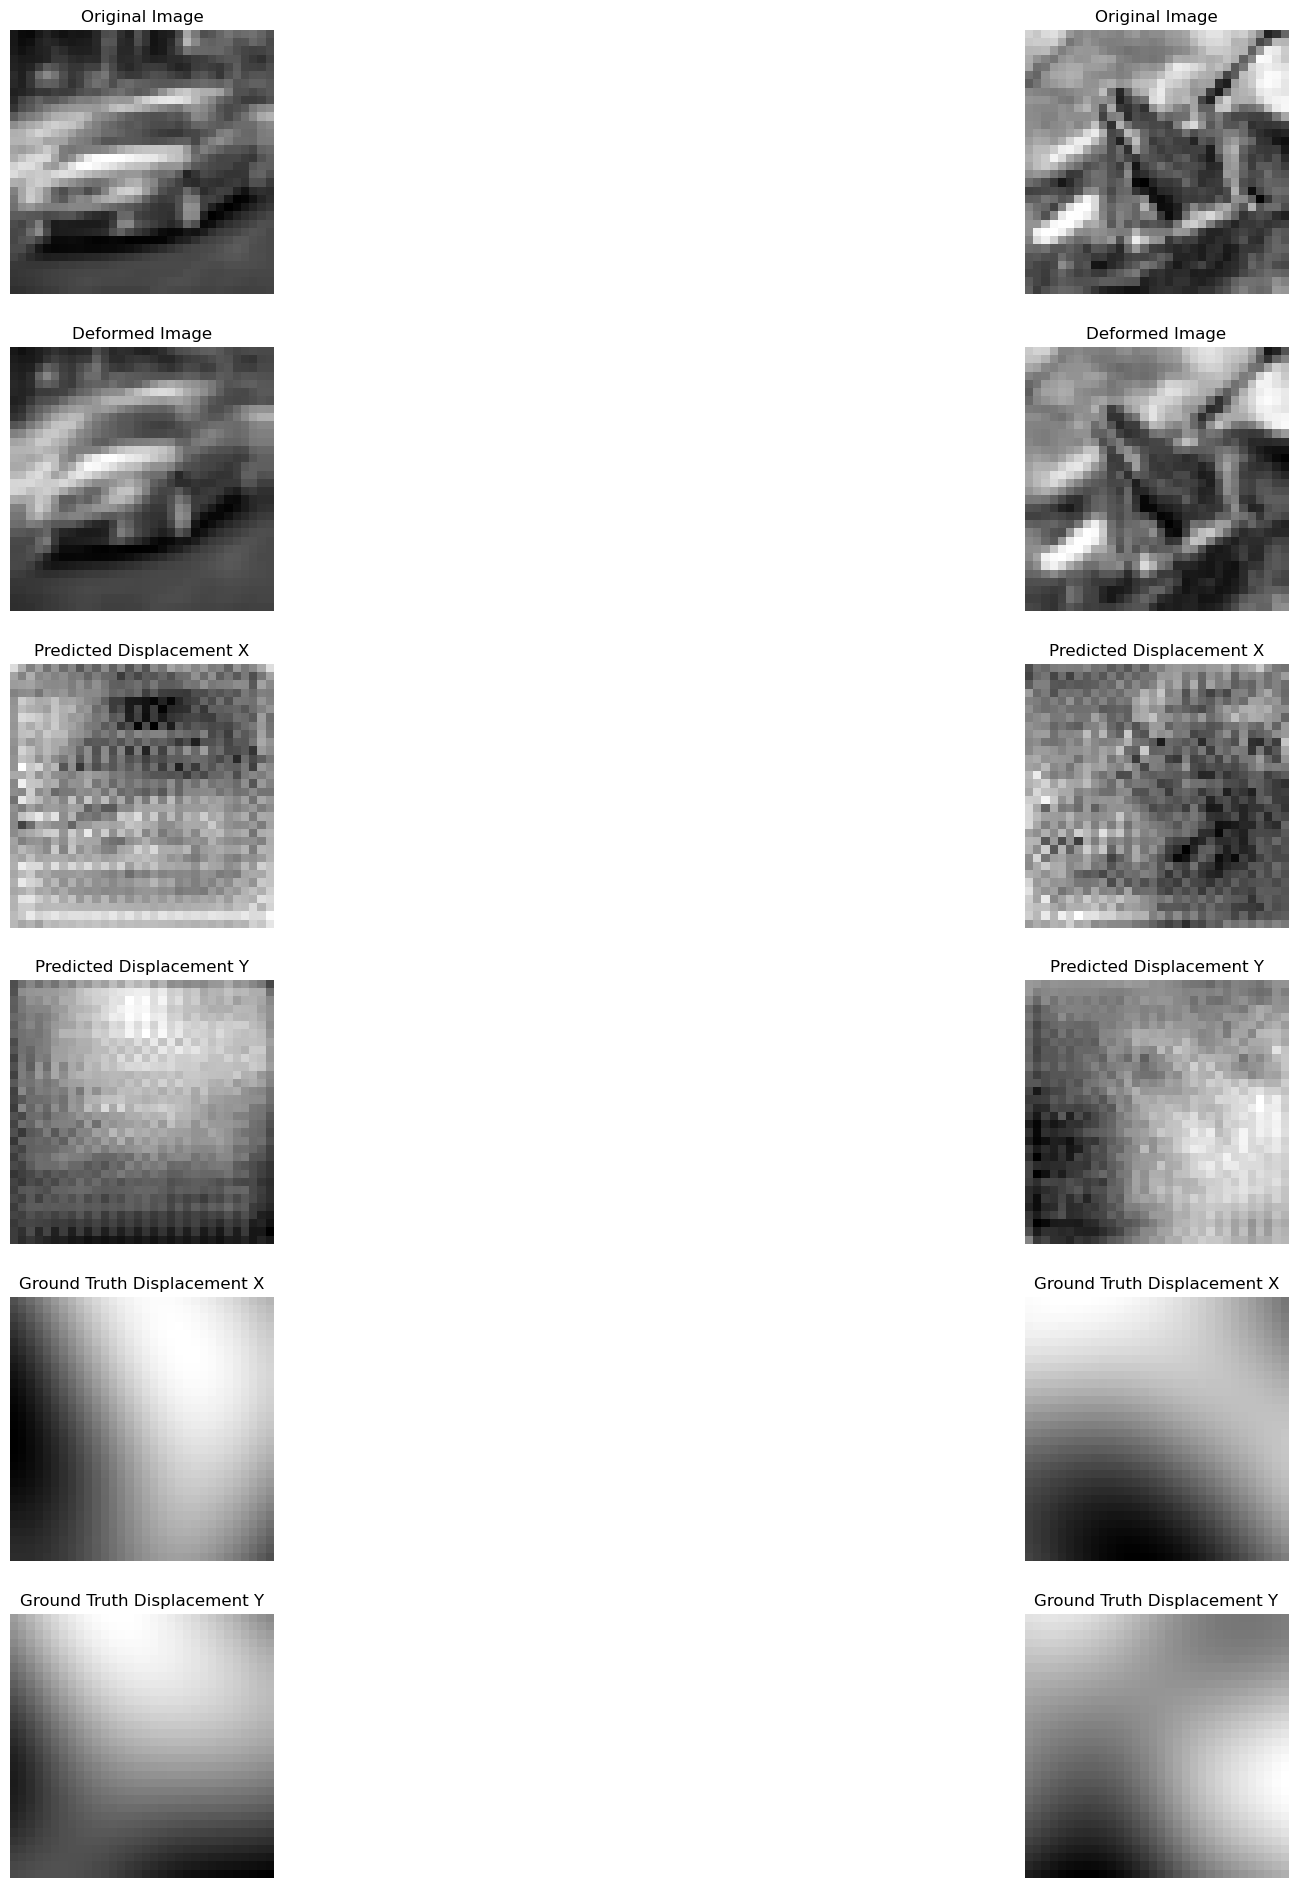

In [14]:
model.eval()
with torch.no_grad():
    images, deformation_fields = next(iter(test_loader))
    # Move data to the device
    images = images.float().to(device)
    deformation_fields = deformation_fields.to(device)
    
    outputs = model(images)
    
    # Plot the original and deformed images
    fig, axes = plt.subplots(6, num_samples, figsize=(24, 24))
    for i in range(num_samples):
        ax = axes[0, i] # [0, i]
        ax.imshow(images[i, 0].cpu().numpy(), cmap='gray')
        ax.title.set_text('Original Image')
        ax.axis('off')

        ax = axes[1, i] # [1, i]
        ax.imshow(images[i, 1].cpu().numpy(), cmap='gray')
        ax.title.set_text('Deformed Image')
        ax.axis('off')

        ax = axes[2, i] # [2, i]
        ax.imshow(outputs[i, 0].cpu().numpy(), cmap='gray')
        ax.title.set_text('Predicted Displacement X')
        ax.axis('off')
        
        ax = axes[3, i]      
        ax.imshow(outputs[i, 1].cpu().numpy(), cmap='gray')
        ax.title.set_text('Predicted Displacement Y')
        ax.axis('off')
        
        ax = axes[4, i]
        ax.imshow(deformation_fields[i, 0].cpu().numpy(), cmap='gray')
        ax.title.set_text('Ground Truth Displacement X')
        ax.axis('off')
        
        ax = axes[5, i]
        ax.imshow(deformation_fields[i, 1].cpu().numpy(), cmap='gray')
        ax.title.set_text('Ground Truth Displacement Y')
        ax.axis('off')